## Biblioteca importadas

In [161]:

import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt




## Leitura das bases de dados de cada aeroportos


#### Frequencia de passageiros no aeroporto CWB

In [162]:
#nacional 
filename = r'C:Passageiros pagos\cwb_nac.xlsx'
cwb_nac = pd.read_excel(filename).drop(["Unnamed: 0"],axis=1)

#internacional
filename = r'C:Passageiros pagos\cwb_int.xlsx'
cwb_int = (pd.read_excel(filename)
 .drop(["Unnamed: 0"],axis=1)
 .rename(columns ={'Passageiros':'Passageiros internacionais'})
          )


#### Frequencia de passageiros no aeroporto IGU

In [163]:
#nacional
filename = r'C:Passageiros pagos\igu_nac.xlsx'
igu_nac = pd.read_excel(filename).drop(["Unnamed: 0"],axis=1)

#internacional
filename = r'C:Passageiros pagos\igu_int.xlsx'
igu_int = (pd.read_excel(filename)
 .drop(["Unnamed: 0"],axis=1)
 .rename(columns ={'Passageiros':'Passageiros internacionais'})
          )

#### Frequencia de passageiros no aeroporto NVT

In [164]:
#nacional
filename = r'C:Passageiros pagos\nvt_nac.xlsx'
nvt_nac = pd.read_excel(filename).drop(["Unnamed: 0"],axis=1)

#internacional
filename = r'C:Passageiros pagos\nvt_int.xlsx'
nvt_int = (pd.read_excel(filename)
 .drop(["Unnamed: 0"],axis=1)
 .rename(columns ={'Passageiros':'Passageiros internacionais'})
          )

#### Frequencia de passageiros no aeroporto PMW

In [165]:
filename = r'C:Passageiros pagos\pmw.xlsx'
pmw = pd.read_excel(filename).drop(["Unnamed: 0"],axis=1)

#### Frequencia de passageiros no aeroporto SLZ

In [166]:
filename = r'C:Passageiros pagos\slz.xlsx'
slz = pd.read_excel(filename).drop(["Unnamed: 0"],axis=1)

## Variaveis macro economicas

#### Valor do barril de petróleo

In [167]:
filename = r'C:Dados macros\statistic_id262858_opec-oil-price-annually-1960-2022.xlsx'
oil = pd.read_excel(filename)

#### Cotação do dolar

In [168]:
filename = r'C:Dados macros\Base de dados Dólar.xlsx'
dolar = pd.read_excel(filename)
dolar = dolar.drop(["valor"], axis =1)


#### Inflação do turismo no Brasil

In [169]:
filename = r'C:Dados macros\statistic_id270812_inflation-rate-in-brazil-2027.xlsx'
inflacao = pd.read_excel(filename)
inflacao = inflacao.drop(["valor"], axis =1)


#### PIB do Brasil e dos Estados dos aeroportos 

In [170]:
filename = r'C:Dados macros\PIB_brasil_freq.xlsx'
pib = pd.read_excel(filename)
pib = pib.drop(["valor"], axis =1)

## Curitiba

##### juntando os pontos macros e uma unico DataFrame

In [171]:
principal_cwb =(cwb_nac
 .join(cwb_int.set_index('Ano'),on='Ano')
 .join(oil.set_index('Ano'),on='Ano')
 .join(dolar.set_index('Ano'),on='Ano')
 .join(inflacao.set_index('Ano'),on='Ano')
 .join(pib.set_index('Ano'),on='Ano')
          )


#### Correlação entre os dados pré selecionados 

In [172]:
principal_cwb.loc[principal_cwb["Ano"] == 2019, "Passageiros_freq_defasagem"] = 0 
principal_cwb = principal_cwb.loc[principal_cwb["Ano"]<2020]

principal_cwb.drop(["Passageiros internacionais","Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).corr()


,Passageiros_freq_defasagem,Câmbio,Inflação,PIB real Brasil
Passageiros_freq_defasagem,1.000000,-0.378978,-0.229385,0.427399
Câmbio,-0.378978,1.000000,0.077090,-0.058331
Inflação,-0.229385,0.077090,1.000000,-0.353719
PIB real Brasil,0.427399,-0.058331,-0.353719,1.000000


#### Análise grafica 

Utilizamos todas as variaveis em loglog para retirar a tendencia dos dados. Nos gráficos de linha em todos eles, os eixos x é o Ano e os eixos y é a variação do dados que está legendado em cada um dos gráficos.

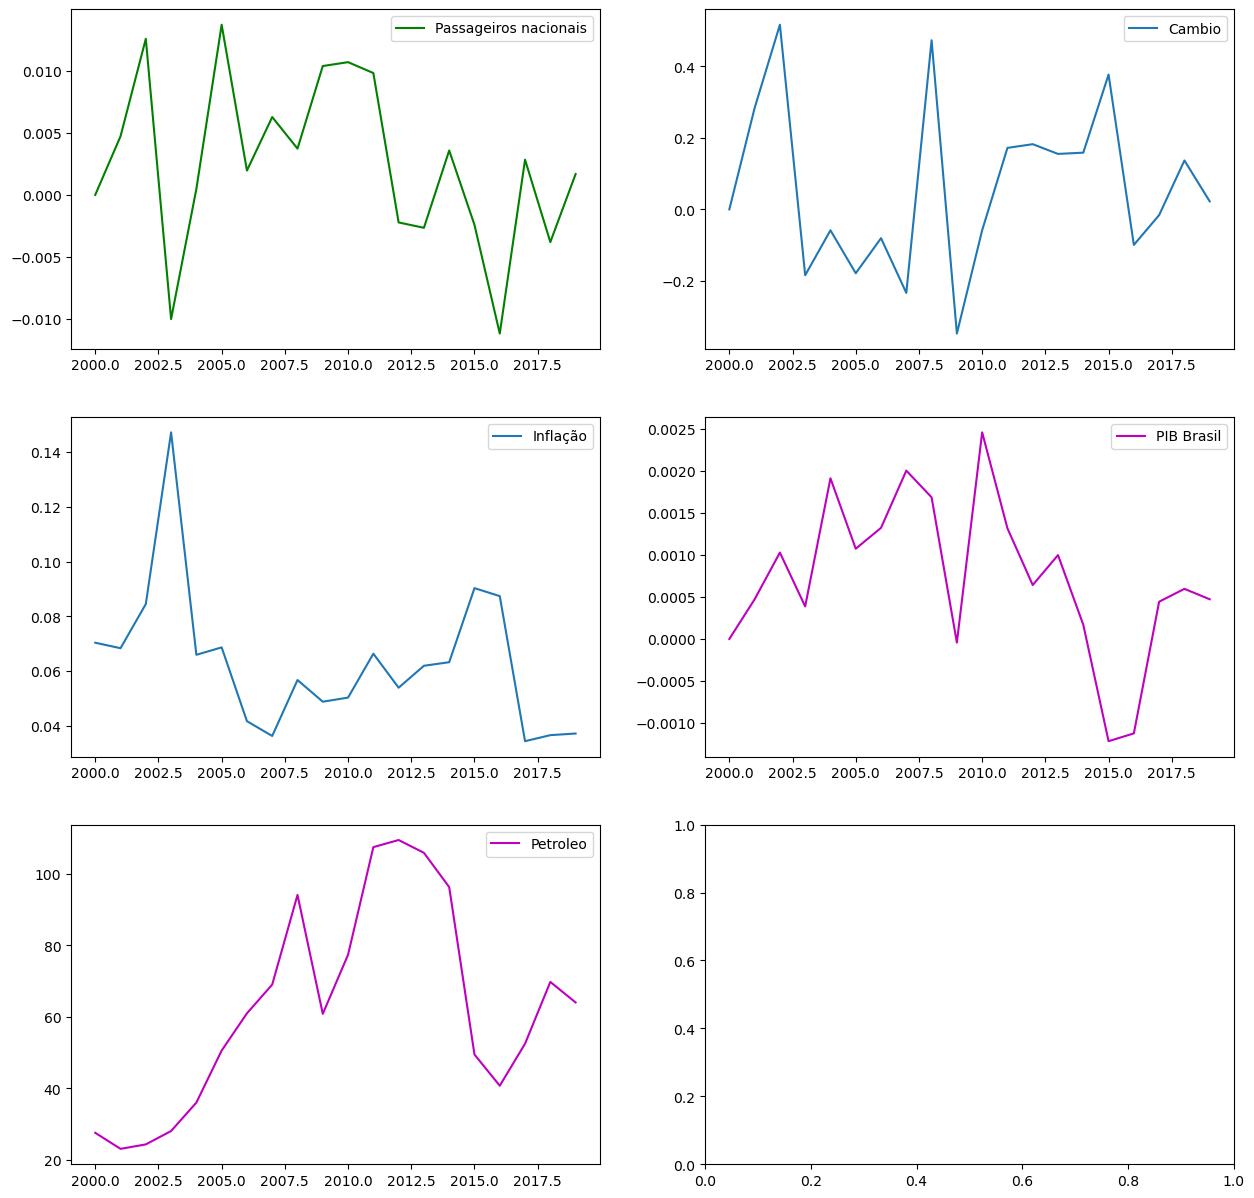

In [173]:
fig, ax = plt.subplots(3,2)

fig.set_size_inches(15,15)



ax[0,0].plot(principal_cwb["Ano"], principal_cwb["Passageiros_frequencia"],"g", label='Passageiros nacionais')
ax[0,0].legend()


ax[0,1].plot(principal_cwb["Ano"], principal_cwb["Câmbio"], label = 'Cambio' )
ax[0,1].legend()

ax[1,0].plot(principal_cwb["Ano"], principal_cwb["Inflação"], label='Inflação')
ax[1,0].legend()


ax[1,1].plot(principal_cwb["Ano"], principal_cwb["PIB real Brasil"],"m", label = 'PIB Brasil' )
ax[1,1].legend()

ax[2,0].plot(principal_cwb["Ano"], principal_cwb["Oil"],"m", label='Petroleo')
ax[2,0].legend()

plt.show()

#### Dividindo a base de dados em treinamento e teste 

Nas duas células de códigos seguintes temos a parte de treinamento e teste. O treino foi definido do ano 2000 até 2017 e na parte foi colocado todos os anos de 2000 até 2019. A variavel Y(a ser prevista) foi colocado a frequencia dos passageiros e nas variaveis X (Cambio, PIB real do Brasil e Inflação) e foi retirada todas as outras.

In [174]:
# Para treinamento utilizamos de 2000 até 2017
treino = principal_cwb.loc[principal_cwb["Ano"] < 2017]

# Para teste utilizamos de 2000 até 2019
teste = principal_cwb.loc[principal_cwb["Ano"] >= 2000]

In [175]:
y_train= treino["Passageiros_frequencia"].copy()
y_test= teste["Passageiros_frequencia"].copy()

X_train = treino.drop(["Passageiros_frequencia", "Passageiros internacionais","Ano","numero_de_passageiros","Oil"],axis=1).copy()
X_test = teste.drop(["Passageiros_frequencia", "Passageiros internacionais","Ano", "numero_de_passageiros","Oil"],axis=1).copy()

#### Validação da regressao linear


In [176]:
reg= LinearRegression()
reg.fit(X_train, y_train)
YpredL= reg.predict(X_test)
erro = np.sqrt(mean_squared_error(y_test, YpredL))


#### Dados da regressão

In [177]:
print(f"Coeficiente da regressão linear: {reg.coef_}")
print(f"Coeficiente angular da reta: {reg.intercept_}")
print(reg.get_params())
print(f"O erro do modelo sem ajuste foi: {erro}")

Coeficiente da regressão linear: [-2.64386919e-01  1.46311138e-04 -1.22504636e-01  3.07289999e+00]
Coeficiente angular da reta: 0.009725204828227823
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
O erro do modelo sem ajuste foi: 0.005720584131793195


##### Tentativa de melhora para a regressão

In [178]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('lin_reg', LinearRegression())
    #('lin_reg', Ridge(alpha=ALPHA))
])

params = {
    'poly__degree': [1,2,3]
}

clf_pipe = GridSearchCV(pipe, params, cv=3, n_jobs=-1)

clf_pipe.fit(X_train, y_train)

print(clf_pipe.best_params_)

{'poly__degree': 1}


In [179]:
y_pred_pipeline = clf_pipe.predict(X_train)

##### Erro com ajuste

In [180]:
erro = np.sqrt(mean_squared_error(y_train, y_pred_pipeline))

print(f"O erro do modelo com ajuste foi: {erro}")

O erro do modelo com ajuste foi: 0.00540147948584624


##### RMSE

In [181]:
final_model = clf_pipe.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f'RMSE = {final_rmse}')

RMSE = 0.005720584131793201


#### Analise com OLS

A regressão linear está analisando um periodo de tempo de 19 anos, se iniciando em 2000 até 2019. Foi utilizada a biblioteca OLS (statsmoldels)

In [182]:
import statsmodels.api as sm

#define response variable
y = principal_cwb["Passageiros_frequencia"].loc[principal_cwb["Ano"]<2020]

#define predictor variables
x = principal_cwb.drop(["Passageiros_frequencia", "Passageiros internacionais","Ano","numero_de_passageiros","Oil"],axis=1).loc[principal_cwb["Ano"]<2020]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     Passageiros_frequencia   R-squared:                       0.335
Model:                                OLS   Adj. R-squared:                  0.158
Method:                     Least Squares   F-statistic:                     1.889
Date:                    Sun, 27 Nov 2022   Prob (F-statistic):              0.165
Time:                            14:11:41   Log-Likelihood:                 75.816
No. Observations:                      20   AIC:                            -141.6
Df Residuals:                          15   BIC:                            -136.7
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

##### Grafico Verdadeiro X Predito

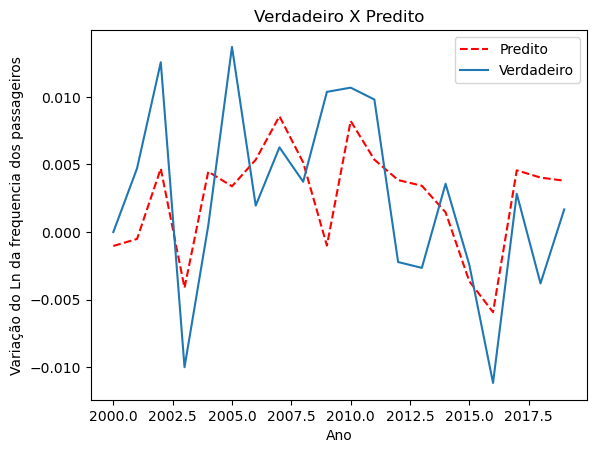

In [183]:
ypred = model.predict(x)
ano_lista = np.arange(2000,2020,1)


plt.plot(ano_lista,ypred,'--r', label='Predito')
plt.plot(ano_lista, principal_cwb["Passageiros_frequencia"], label = 'Verdadeiro' )
plt.title("Verdadeiro X Predito")
plt.xlabel("Ano")
plt.ylabel("Variação do Ln da frequencia dos passageiros")
plt.legend()
plt.show()

## Foz do Iguaçu

##### juntando os pontos macros e uma unico DataFrame

In [184]:
principal_igu =(igu_nac
 .join(igu_int.set_index('Ano'),on='Ano')
 .join(oil.set_index('Ano'),on='Ano')
 .join(dolar.set_index('Ano'),on='Ano')
 .join(inflacao.set_index('Ano'),on='Ano')
 .join(pib.set_index('Ano'),on='Ano')
          )

##### Correlação entre os dados pré selecionados 

In [185]:
principal_igu.loc[principal_igu["Ano"] == 2019, "Passageiros_freq_defasagem"] = 0 
principal_igu = principal_igu.loc[principal_igu["Ano"]<2020]

principal_igu.drop(["Passageiros internacionais","Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).corr()


,Passageiros_freq_defasagem,Câmbio,Inflação,PIB real Brasil
Passageiros_freq_defasagem,1.000000,-0.362140,0.128012,0.282233
Câmbio,-0.362140,1.000000,0.077090,-0.058331
Inflação,0.128012,0.077090,1.000000,-0.353719
PIB real Brasil,0.282233,-0.058331,-0.353719,1.000000


##### Análise grafica

Utilizamos todas as variaveis em loglog para retirar a tendencia dos dados. Nos gráficos de linha em todos eles, os eixos x é o Ano e os eixos y é a variação do dados que está legendado em cada um dos gráficos.

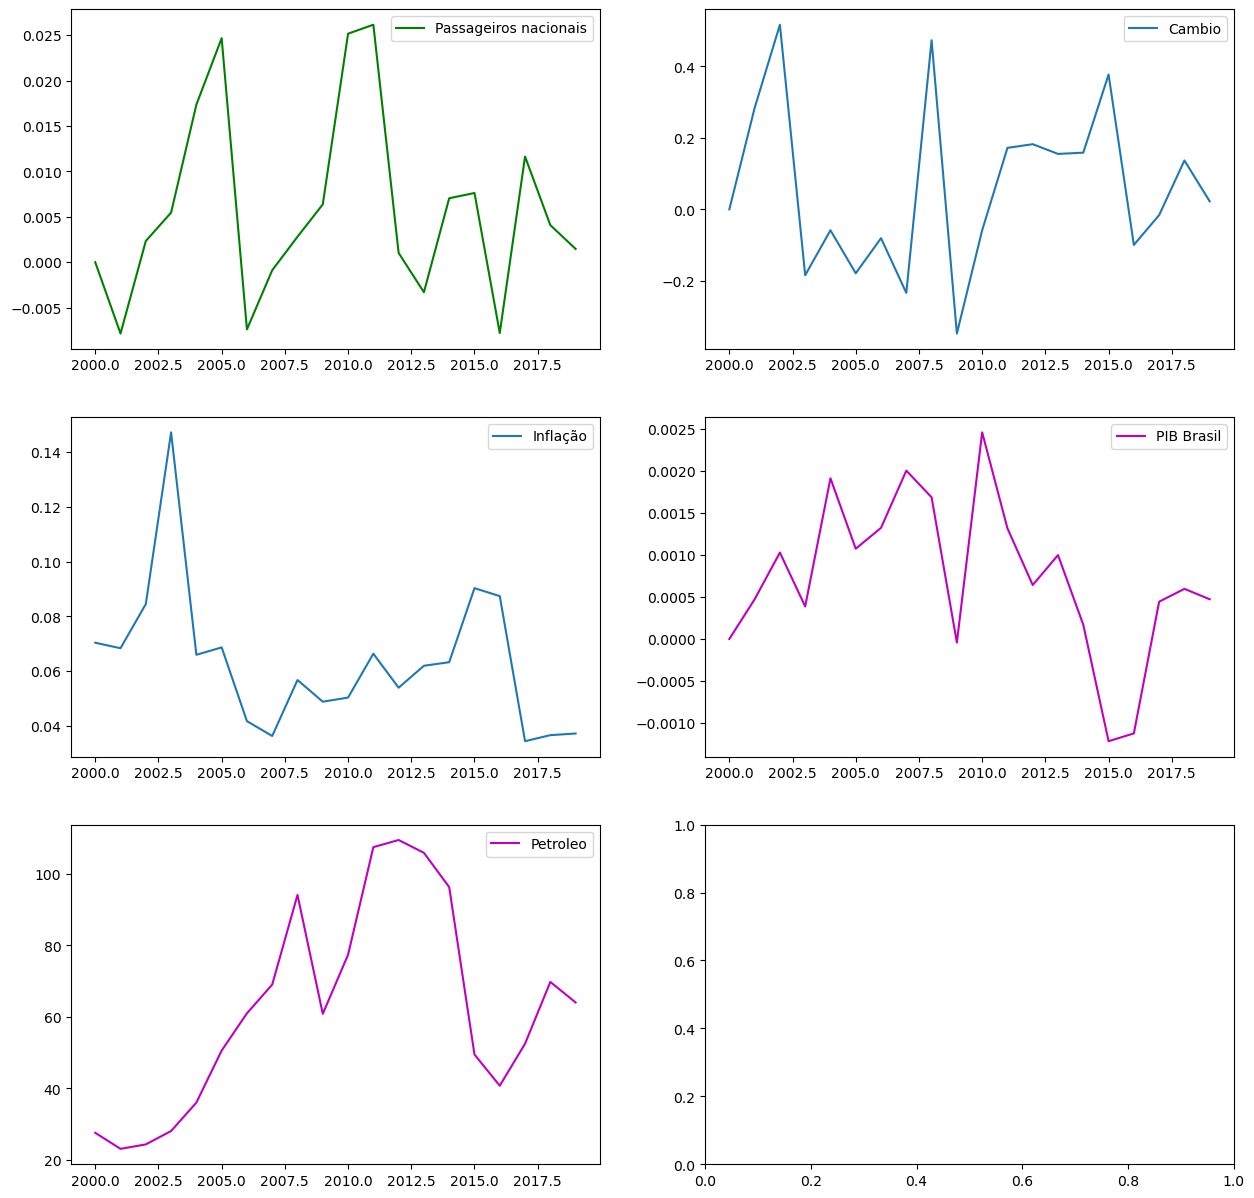

In [186]:
fig, ax = plt.subplots(3,2)

fig.set_size_inches(15,15)



ax[0,0].plot(principal_igu["Ano"], principal_igu["Passageiros_frequencia"],"g", label='Passageiros nacionais')
ax[0,0].legend()

ax[0,1].plot(principal_igu["Ano"], principal_igu["Câmbio"], label = 'Cambio' )
ax[0,1].legend()

ax[1,0].plot(principal_igu["Ano"], principal_igu["Inflação"], label='Inflação')
ax[1,0].legend()

ax[1,1].plot(principal_igu["Ano"], principal_igu["PIB real Brasil"],"m", label = 'PIB Brasil' )
ax[1,1].legend()

ax[2,0].plot(principal_igu["Ano"], principal_igu["Oil"],"m", label='Petroleo')
ax[2,0].legend()

plt.show()

#### Dividindo a base de dados em treinamento e teste

Nas duas células de códigos seguintes temos a parte de treinamento e teste. O treino foi definido do ano 2000 até 2017 e na parte foi colocado todos os anos de 2000 até 2019. A variavel Y(a ser prevista) foi colocado a frequencia dos passageiros e nas variaveis X (Cambio, PIB real do Brasil e Inflação) e foi retirada todas as outras.

In [187]:
treino = principal_igu.loc[principal_igu["Ano"] < 2017]
teste = principal_igu.loc[principal_igu["Ano"] >= 2000]

In [188]:
y_train= treino["Passageiros_frequencia"].copy()
y_test= teste["Passageiros_frequencia"].copy()

X_train = treino.drop(["Passageiros_frequencia", "Passageiros internacionais","Ano","numero_de_passageiros","Oil"],axis=1).copy()
X_test = teste.drop(["Passageiros_frequencia", "Passageiros internacionais","Ano","numero_de_passageiros","Oil"],axis=1).copy()

### Regresao linear

In [189]:
reg= LinearRegression()
reg.fit(X_train, y_train)
YpredL= reg.predict(X_test)
erro = np.sqrt(mean_squared_error(y_test, YpredL))



#### Dados da regrssao

In [190]:
print(f"Coeficiente da regressão linear: {reg.coef_}")
print(f"Coeficiente angular da reta: {reg.intercept_}")
print(f"O erro do modelo sem ajuste foi: {erro}")

Coeficiente da regressão linear: [ 3.22445222e-02 -5.00918193e-03  9.67117583e-02  5.19209915e+00]
Coeficiente angular da reta: -0.00469367095218824
O erro do modelo sem ajuste foi: 0.009315659584372828


##### Tentativa de melhora para a regrssao

In [191]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('lin_reg', LinearRegression())
])

params = {
    'poly__degree': [1,2,3]
}

clf_pipe = GridSearchCV(pipe, params, cv=3, n_jobs=-1)

clf_pipe.fit(X_train, y_train)

print(clf_pipe.best_params_)

{'poly__degree': 1}


In [192]:
y_pred_pipeline = clf_pipe.predict(X_train)

##### Erro com ajuste

In [193]:
erro = np.sqrt(mean_squared_error(y_train, y_pred_pipeline))

print(f"O erro do modelo com ajuste foi: {erro}")

O erro do modelo com ajuste foi: 0.00975636125777233


##### RMSE

In [194]:
final_model = clf_pipe.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f'RMSE = {final_rmse}')

RMSE = 0.00931565958437283


#### Analise com OLS

A regressão linear está analisando um periodo de tempo de 19 anos, se iniciando em 2000 até 2019. Foi utilizada a biblioteca OLS (statsmoldels)

In [195]:
import statsmodels.api as sm

#define response variable
y = principal_igu["Passageiros_frequencia"].loc[principal_igu["Ano"]<2020]

#define predictor variables
x = principal_igu.drop(["Passageiros_frequencia", "Passageiros internacionais","Ano","numero_de_passageiros","Oil"],axis=1).loc[principal_igu["Ano"]<2020]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     Passageiros_frequencia   R-squared:                       0.182
Model:                                OLS   Adj. R-squared:                 -0.036
Method:                     Least Squares   F-statistic:                    0.8343
Date:                    Sun, 27 Nov 2022   Prob (F-statistic):              0.524
Time:                            14:11:44   Log-Likelihood:                 65.291
No. Observations:                      20   AIC:                            -120.6
Df Residuals:                          15   BIC:                            -115.6
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

##### Grafico Verdadeiro X Predito

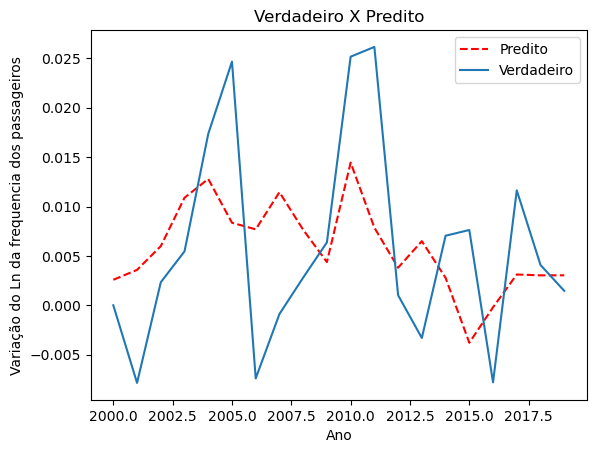

In [196]:
ypred = model.predict(x)
ano_lista = np.arange(2000,2020,1)


plt.plot(ano_lista,ypred,'--r', label='Predito')
plt.plot(ano_lista, principal_igu["Passageiros_frequencia"], label = 'Verdadeiro' )
plt.title("Verdadeiro X Predito")
plt.xlabel("Ano")
plt.ylabel("Variação do Ln da frequencia dos passageiros")
plt.legend()
plt.show()

## Navegantes

##### juntando os pontos macros e uma unico DataFrame

In [197]:
principal_nvt =(nvt_nac
 .join(nvt_int.set_index('Ano'),on='Ano')
 .join(oil.set_index('Ano'),on='Ano')
 .join(dolar.set_index('Ano'),on='Ano')
 .join(inflacao.set_index('Ano'),on='Ano')
 .join(pib.set_index('Ano'),on='Ano')
          )

##### Correlação entre os dados pré selecionados 

In [198]:
 
principal_nvt = principal_nvt.loc[principal_nvt["Ano"]<2020]

principal_nvt.drop(["Passageiros internacionais","Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).corr()


,Passageiros_freq_defasagem,Câmbio,Inflação,PIB real Brasil
Passageiros_freq_defasagem,1.000000,-0.136459,0.048770,0.207299
Câmbio,-0.136459,1.000000,0.077090,-0.058331
Inflação,0.048770,0.077090,1.000000,-0.353719
PIB real Brasil,0.207299,-0.058331,-0.353719,1.000000


##### Análise grafica

Utilizamos todas as variaveis em loglog para retirar a tendencia dos dados. Nos gráficos de linha em todos eles, os eixos x é o Ano e os eixos y é a variação do dados que está legendado em cada um dos gráficos.

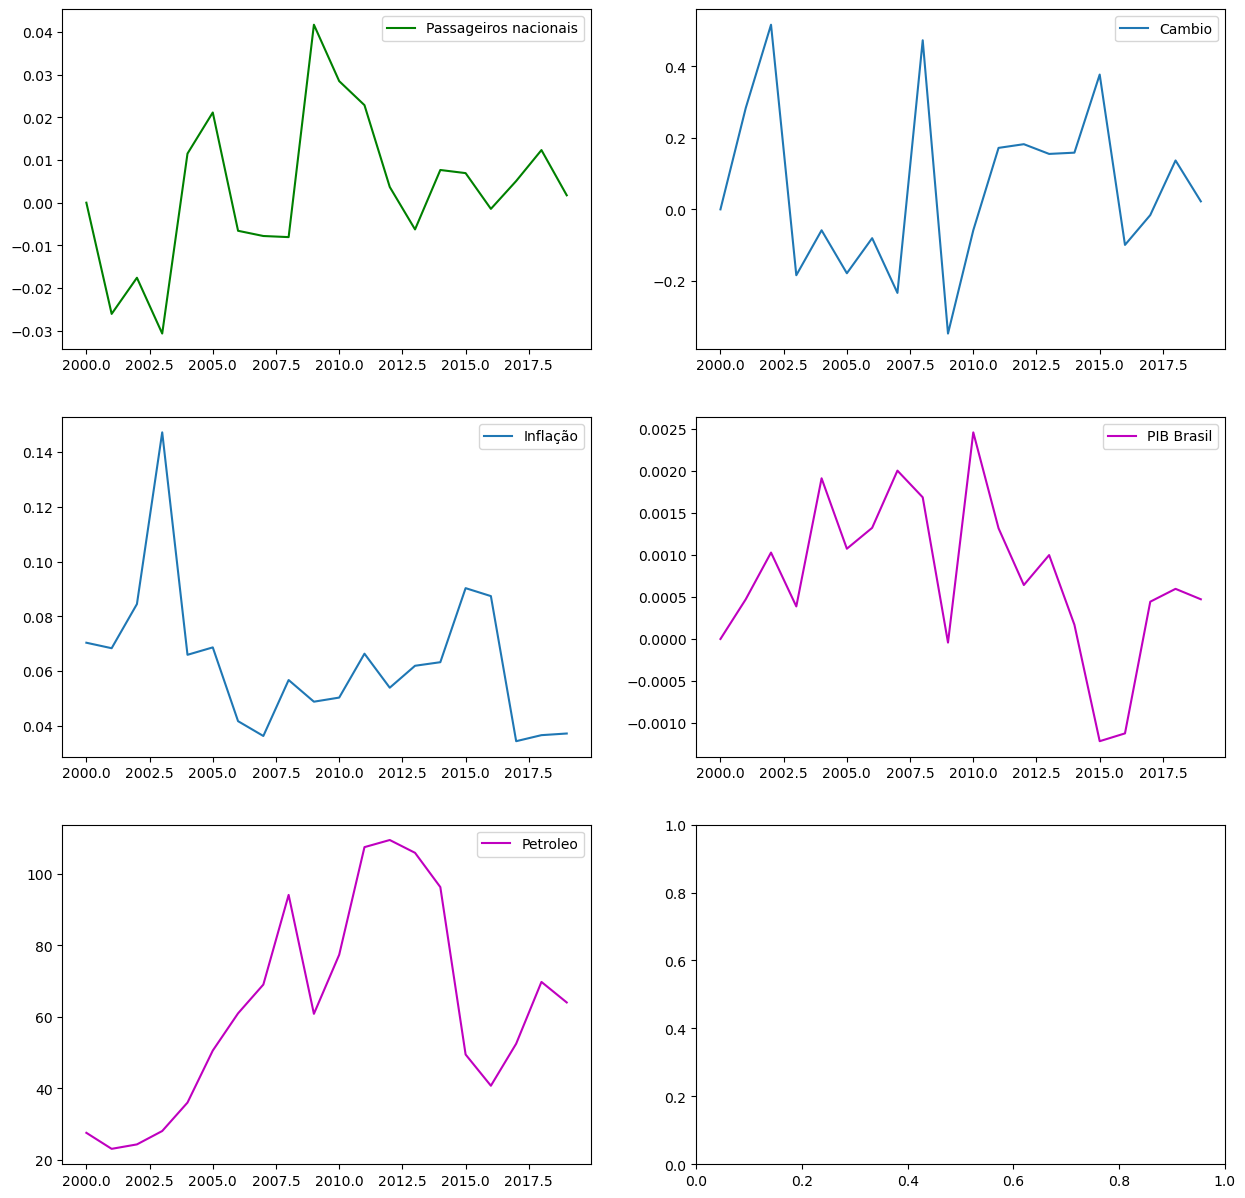

In [199]:
fig, ax = plt.subplots(3,2)

fig.set_size_inches(15,15)



ax[0,0].plot(principal_nvt["Ano"], principal_nvt["Passageiros_frequencia"],"g", label='Passageiros nacionais')
ax[0,0].legend()




ax[0,1].plot(principal_nvt["Ano"], principal_nvt["Câmbio"], label = 'Cambio' )
ax[0,1].legend()

ax[1,0].plot(principal_nvt["Ano"], principal_nvt["Inflação"], label='Inflação')
ax[1,0].legend()


ax[1,1].plot(principal_nvt["Ano"], principal_nvt["PIB real Brasil"],"m", label = 'PIB Brasil' )
ax[1,1].legend()

ax[2,0].plot(principal_nvt["Ano"], principal_nvt["Oil"],"m", label='Petroleo')
ax[2,0].legend()

plt.show()

#### Dividindo a base de dados em treinamento e teste

Nas duas células de códigos seguintes temos a parte de treinamento e teste. O treino foi definido do ano 2000 até 2017 e na parte foi colocado todos os anos de 2000 até 2019. A variavel Y(a ser prevista) foi colocado a frequencia dos passageiros e nas variaveis X (Cambio, PIB real do Brasil e Inflação) e foi retirada todas as outras.

In [200]:
treino = principal_nvt.loc[principal_nvt["Ano"] < 2017]
teste = principal_nvt.loc[principal_nvt["Ano"] >= 2000]

In [201]:
y_train= treino["Passageiros_frequencia"].copy()
y_test= teste["Passageiros_frequencia"].copy()

X_train = treino.drop(["Passageiros_frequencia", "Passageiros internacionais","Ano","numero_de_passageiros","Oil"],axis=1).copy()
X_test = teste.drop(["Passageiros_frequencia", "Passageiros internacionais","Ano","numero_de_passageiros","Oil"],axis=1).copy()

### Regresao linear

In [202]:
reg= LinearRegression()
reg.fit(X_train, y_train)
YpredL= reg.predict(X_test)
erro = np.sqrt(mean_squared_error(y_test, YpredL))




#### Dados da regrssao

In [203]:
print(f"Coeficiente da regressão linear: {reg.coef_}")
print(f"Coeficiente angular da reta: {reg.intercept_}")
print(reg.get_params())
print(f"O erro do modelo sem ajuste foi: {erro}")

Coeficiente da regressão linear: [ 0.3621818  -0.02060894 -0.39732499 -4.8627074 ]
Coeficiente angular da reta: 0.033600366493814156
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
O erro do modelo sem ajuste foi: 0.013164326729327382


##### Tentativa de melhora para a regrssao

In [204]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('lin_reg', LinearRegression())
    #('lin_reg', Ridge(alpha=ALPHA))
])

params = {
    'poly__degree': [1,2,3]
}

clf_pipe = GridSearchCV(pipe, params, cv=3, n_jobs=-1)

clf_pipe.fit(X_train, y_train)

print(clf_pipe.best_params_)

{'poly__degree': 1}


In [205]:
y_pred_pipeline = clf_pipe.predict(X_train)

##### Erro com ajuste

In [206]:
erro = np.sqrt(mean_squared_error(y_train, y_pred_pipeline))

print(f"O erro do modelo com ajuste foi: {erro}")

O erro do modelo com ajuste foi: 0.013599126988257956


##### RMSE

In [207]:
final_model = clf_pipe.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f'RMSE = {final_rmse}')

RMSE = 0.013164326729327384


#### Analise com OLS

A regressão linear está analisando um periodo de tempo de 19 anos, se iniciando em 2000 até 2019. Foi utilizada a biblioteca OLS (statsmoldels)

In [208]:
import statsmodels.api as sm

#define response variable
y = principal_nvt["Passageiros_frequencia"].loc[principal_nvt["Ano"]<2020]

#define predictor variables
x = principal_nvt.drop(["Passageiros_frequencia", "Passageiros internacionais","Ano","numero_de_passageiros","Oil"],axis=1).loc[principal_nvt["Ano"]<2020]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     Passageiros_frequencia   R-squared:                       0.427
Model:                                OLS   Adj. R-squared:                  0.274
Method:                     Least Squares   F-statistic:                     2.792
Date:                    Sun, 27 Nov 2022   Prob (F-statistic):             0.0647
Time:                            14:11:46   Log-Likelihood:                 58.408
No. Observations:                      20   AIC:                            -106.8
Df Residuals:                          15   BIC:                            -101.8
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

##### Grafico Verdadeiro X Predito

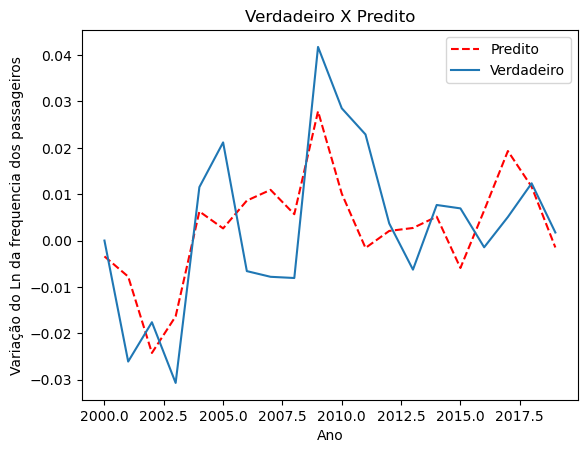

In [209]:
ypred = model.predict(x)
ano_lista = np.arange(2000,2020,1)


plt.plot(ano_lista,ypred,'--r', label='Predito')
plt.plot(ano_lista, principal_nvt["Passageiros_frequencia"], label = 'Verdadeiro' )
plt.title("Verdadeiro X Predito")
plt.xlabel("Ano")
plt.ylabel("Variação do Ln da frequencia dos passageiros")
plt.legend()
plt.show()

## Palmas

##### juntando os pontos macros e uma unico DataFrame

In [210]:
principal_pmw =(pmw
 .join(oil.set_index('Ano'),on='Ano')
 .join(dolar.set_index('Ano'),on='Ano')
 .join(inflacao.set_index('Ano'),on='Ano')
 .join(pib.set_index('Ano'),on='Ano')
          )

##### Correlação entre os dados pré selecionados 

In [211]:
principal_pmw.loc[principal_pmw["Ano"] == 2019, "Passageiros_freq_defasagem"] = 0 
principal_pmw= principal_pmw.loc[principal_pmw["Ano"]<2020]
principal_pmw.drop(["Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).corr()

,Passageiros_freq_defasagem,Câmbio,Inflação,PIB real Brasil
Passageiros_freq_defasagem,1.000000,-0.418795,0.546400,0.037045
Câmbio,-0.418795,1.000000,0.077090,-0.058331
Inflação,0.546400,0.077090,1.000000,-0.353719
PIB real Brasil,0.037045,-0.058331,-0.353719,1.000000


##### Análise grafica

Utilizamos todas as variaveis em loglog para retirar a tendencia dos dados. Nos gráficos de linha em todos eles, os eixos x é o Ano e os eixos y é a variação do dados que está legendado em cada um dos gráficos.

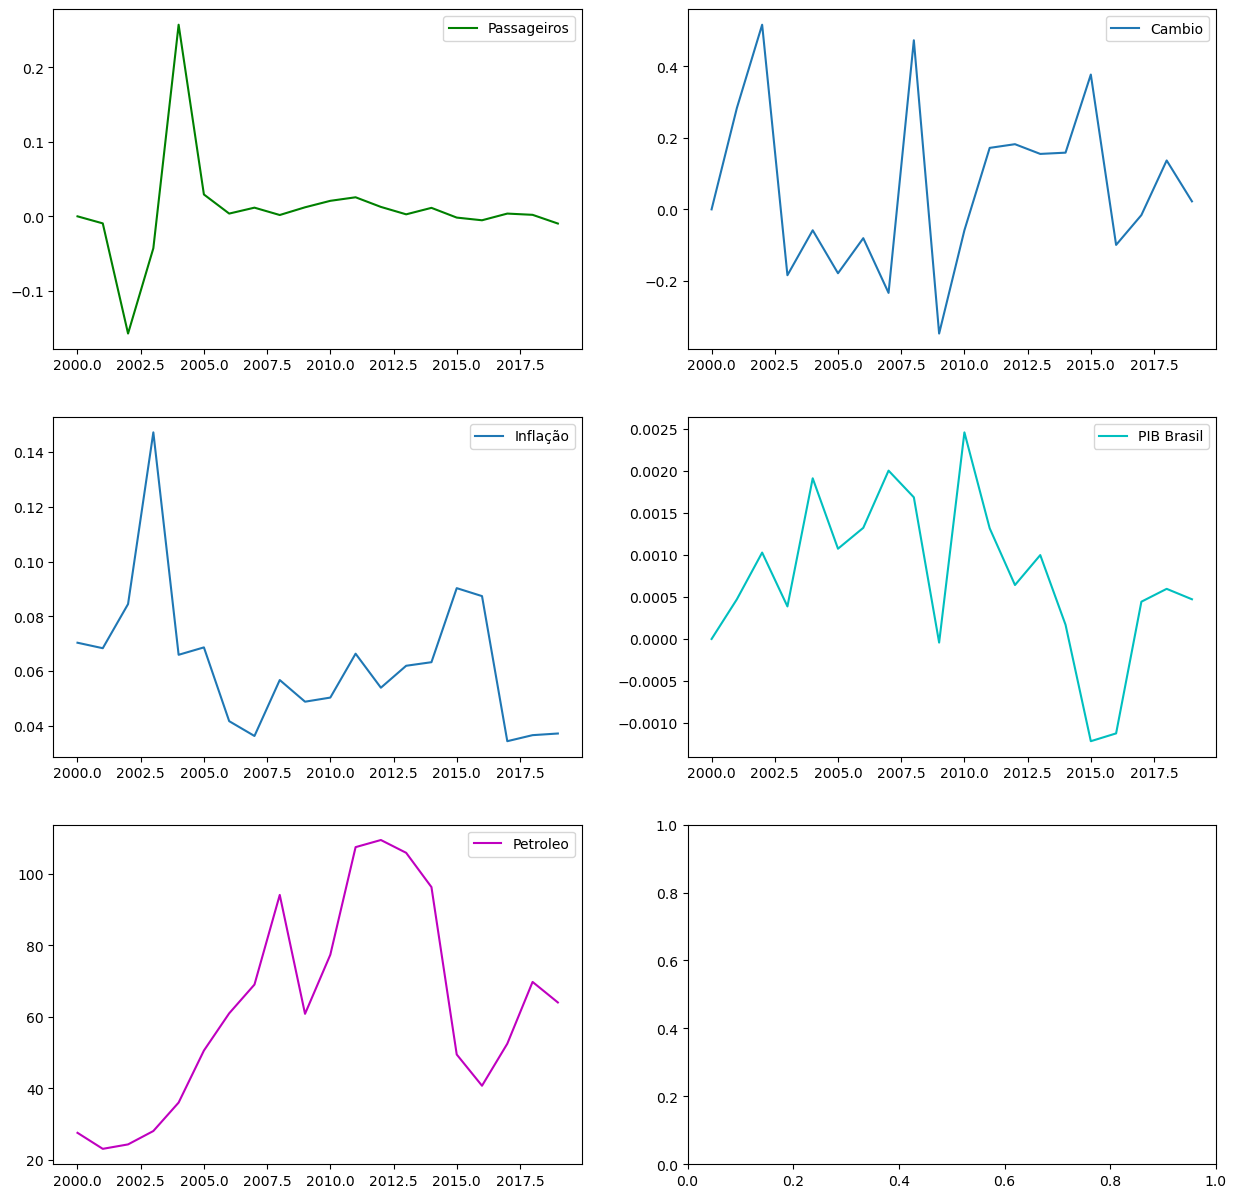

In [212]:
fig, ax = plt.subplots(3,2)

fig.set_size_inches(15,15)


ax[0,0].plot(principal_pmw["Ano"], principal_pmw["Passageiros_frequencia"],"g", label='Passageiros')
ax[0,0].legend()

ax[0,1].plot(principal_pmw["Ano"], principal_pmw["Câmbio"], label = 'Cambio' )
ax[0,1].legend()

ax[1,0].plot(principal_pmw["Ano"], principal_pmw["Inflação"], label='Inflação')
ax[1,0].legend()

ax[1,1].plot(principal_pmw["Ano"], principal_pmw["PIB real Brasil"],"c", label = 'PIB Brasil' )
ax[1,1].legend()


ax[2,0].plot(principal_nvt["Ano"], principal_nvt["Oil"],"m", label='Petroleo')
ax[2,0].legend()



plt.show()

#### Dividindo a base de dados em treinamento e teste

Nas duas células de códigos seguintes temos a parte de treinamento e teste. O treino foi definido do ano 2000 até 2017 e na parte foi colocado todos os anos de 2000 até 2019. A variavel Y(a ser prevista) foi colocado a frequencia dos passageiros e nas variaveis X (Cambio, PIB real do Brasil e Inflação) e foi retirada todas as outras.

In [213]:
treino = principal_pmw.loc[principal_pmw["Ano"] < 2017]
teste = principal_pmw.loc[principal_pmw["Ano"] >= 2000]

In [214]:
y_train= treino["Passageiros_frequencia"].copy()
y_test= teste["Passageiros_frequencia"].copy()

X_train = treino.drop(["Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).copy()
X_test = teste.drop(["Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).copy()

### Regresao linear

In [215]:
reg= LinearRegression()
reg.fit(X_train, y_train)
YpredL= reg.predict(X_test)
erro = np.sqrt(mean_squared_error(y_test, YpredL))



#### Dados da regrssao

In [216]:
print(f"Coeficiente da regressão linear: {reg.coef_}")
print(f"Coeficiente angular da reta: {reg.intercept_}")
print(reg.get_params())
print(f"O erro do modelo sem ajuste foi: {erro}")

Coeficiente da regressão linear: [-1.26940543e-02 -9.85472170e-02 -4.40046180e-01  1.41264903e+01]
Coeficiente angular da reta: 0.035741224690900096
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
O erro do modelo sem ajuste foi: 0.061955309807587386


##### Tentativa de melhora para a regrssao

In [217]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('lin_reg', LinearRegression())
    #('lin_reg', Ridge(alpha=ALPHA))
])

params = {
    'poly__degree': [1,2,3]
}

clf_pipe = GridSearchCV(pipe, params, cv=3, n_jobs=-1)

clf_pipe.fit(X_train, y_train)

print(clf_pipe.best_params_)

{'poly__degree': 1}


In [218]:
y_pred_pipeline = clf_pipe.predict(X_train)

##### Erro com ajuste

In [219]:
erro = np.sqrt(mean_squared_error(y_train, y_pred_pipeline))

print(f"O erro do modelo com ajuste foi: {erro}")

O erro do modelo com ajuste foi: 0.06636811622229252


##### RMSE

In [220]:
final_model = clf_pipe.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f'RMSE = {final_rmse}')

RMSE = 0.061955309807587386


#### Analise com OLS

A regressão linear está analisando um periodo de tempo de 19 anos, se iniciando em 2000 até 2019. Foi utilizada a biblioteca OLS (statsmoldels)

In [221]:
import statsmodels.api as sm

#define response variable
y = principal_pmw["Passageiros_frequencia"].loc[principal_pmw["Ano"]<2020]

#define predictor variables
x = principal_pmw.drop(["Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).loc[principal_pmw["Ano"]<2020]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     Passageiros_frequencia   R-squared:                       0.194
Model:                                OLS   Adj. R-squared:                 -0.021
Method:                     Least Squares   F-statistic:                    0.9002
Date:                    Sun, 27 Nov 2022   Prob (F-statistic):              0.488
Time:                            14:11:49   Log-Likelihood:                 27.361
No. Observations:                      20   AIC:                            -44.72
Df Residuals:                          15   BIC:                            -39.74
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

##### Grafico Verdadeiro X Predito

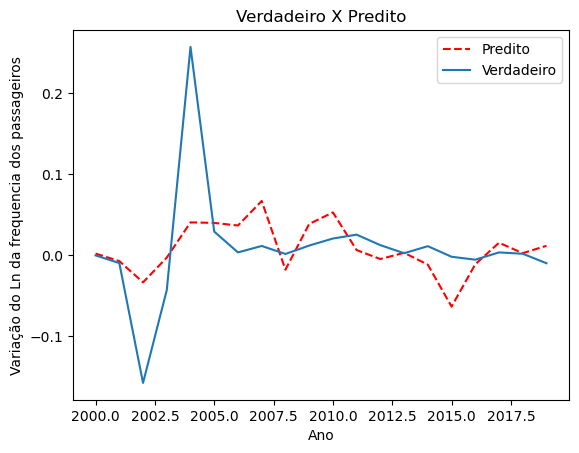

In [222]:
ypred = model.predict(x)
ano_lista = np.arange(2000,2020,1)


plt.plot(ano_lista,ypred,'--r', label='Predito')
plt.plot(ano_lista, principal_pmw["Passageiros_frequencia"], label = 'Verdadeiro' )
plt.title("Verdadeiro X Predito")
plt.xlabel("Ano")
plt.ylabel("Variação do Ln da frequencia dos passageiros")
plt.legend()
plt.show()

## São Luiz

##### juntando os pontos macros e uma unico DataFrame

In [223]:
principal_slz =(slz
 .join(oil.set_index('Ano'),on='Ano')
 .join(dolar.set_index('Ano'),on='Ano')
 .join(inflacao.set_index('Ano'),on='Ano')
 .join(pib.set_index('Ano'),on='Ano')
          )

##### Correlação entre os dados pré selecionados 

In [224]:
principal_slz.loc[principal_slz["Ano"] == 2019, "Passageiros_freq_defasagem"] = 0 
principal_slz= principal_slz.loc[principal_slz["Ano"]<2020]
principal_slz.drop(["Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).corr()


,Passageiros_freq_defasagem,Câmbio,Inflação,PIB real Brasil
Passageiros_freq_defasagem,1.000000,-0.358100,0.157277,0.275966
Câmbio,-0.358100,1.000000,0.077090,-0.058331
Inflação,0.157277,0.077090,1.000000,-0.353719
PIB real Brasil,0.275966,-0.058331,-0.353719,1.000000


##### Análise grafica

Utilizamos todas as variaveis em loglog para retirar a tendencia dos dados. Nos gráficos de linha em todos eles, os eixos x é o Ano e os eixos y é a variação do dados que está legendado em cada um dos gráficos.

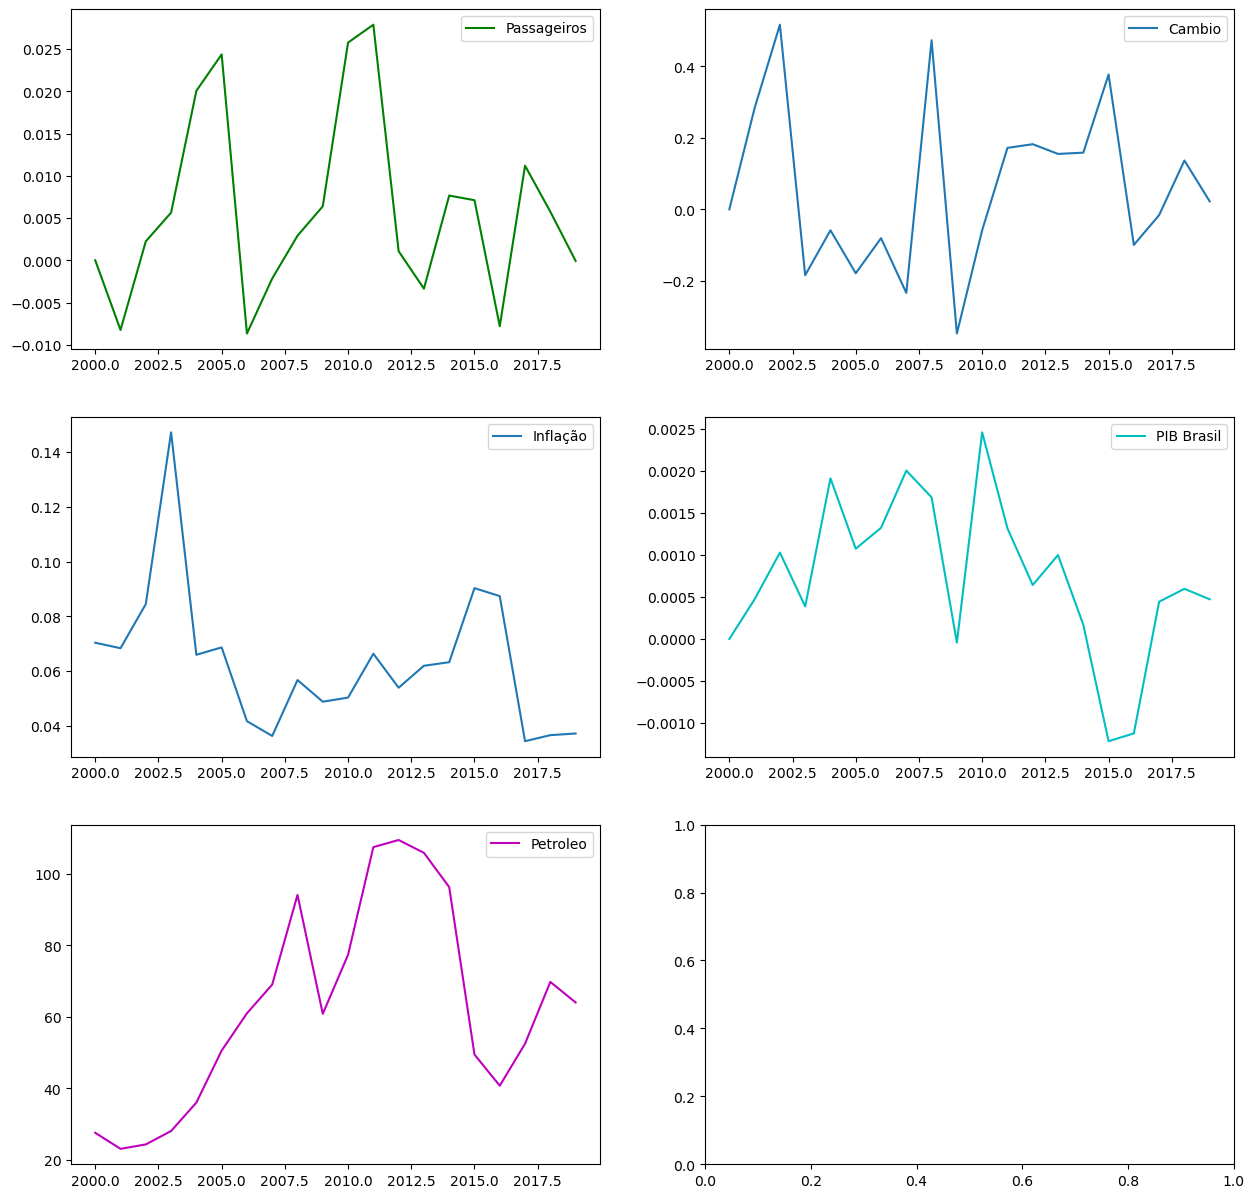

In [225]:
fig, ax = plt.subplots(3,2)

fig.set_size_inches(15,15)


ax[0,0].plot(principal_slz["Ano"], principal_slz["Passageiros_frequencia"],"g", label='Passageiros')
ax[0,0].legend()



ax[0,1].plot(principal_slz["Ano"], principal_slz["Câmbio"], label = 'Cambio' )
ax[0,1].legend()

ax[1,0].plot(principal_slz["Ano"], principal_slz["Inflação"], label='Inflação')
ax[1,0].legend()

ax[1,1].plot(principal_slz["Ano"], principal_slz["PIB real Brasil"],"c", label = 'PIB Brasil' )
ax[1,1].legend()


ax[2,0].plot(principal_slz["Ano"], principal_slz["Oil"],"m", label='Petroleo')
ax[2,0].legend()



plt.show()#

#### Dividindo a base de dados em treinamento e teste

Nas duas células de códigos seguintes temos a parte de treinamento e teste. O treino foi definido do ano 2000 até 2017 e na parte foi colocado todos os anos de 2000 até 2019. A variavel Y(a ser prevista) foi colocado a frequencia dos passageiros e nas variaveis X (Cambio, PIB real do Brasil e Inflação) e foi retirada todas as outras.

In [226]:
treino = principal_slz.loc[principal_slz["Ano"] < 2017]
teste = principal_slz.loc[principal_slz["Ano"] >= 2000]

In [227]:
y_train= treino["Passageiros_frequencia"].copy()
y_test= teste["Passageiros_frequencia"].copy()

X_train = treino.drop(["Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).copy()
X_test = teste.drop(["Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).copy()

### Regresao linear

In [228]:
reg= LinearRegression()
reg.fit(X_train, y_train)
YpredL= reg.predict(X_test)
erro = np.sqrt(mean_squared_error(y_test, YpredL))



#### Dados da regrssao

In [229]:
print(f"Coeficiente da regressão linear: {reg.coef_}")
print(f"Coeficiente angular da reta: {reg.intercept_}")
print(reg.get_params())
print(f"O erro do modelo sem ajuste foi: {erro}")

Coeficiente da regressão linear: [ 6.49308612e-02 -4.25987912e-03  1.02121591e-01  5.36623636e+00]
Coeficiente angular da reta: -0.0053368076587984046
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
O erro do modelo sem ajuste foi: 0.009789083838715512


##### Tentativa de melhora para a regrssao

In [230]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('lin_reg', LinearRegression())
    #('lin_reg', Ridge(alpha=ALPHA))
])

params = {
    'poly__degree': [1,2,3]
}

clf_pipe = GridSearchCV(pipe, params, cv=3, n_jobs=-1)

clf_pipe.fit(X_train, y_train)

print(clf_pipe.best_params_)

{'poly__degree': 1}


In [231]:
y_pred_pipeline = clf_pipe.predict(X_train)

##### Erro com ajuste

In [232]:
erro = np.sqrt(mean_squared_error(y_train, y_pred_pipeline))

print(f"O erro do modelo com ajuste foi: {erro}")

O erro do modelo com ajuste foi: 0.010259169184529404


##### RMSE

In [233]:
final_model = clf_pipe.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f'RMSE = {final_rmse}')

RMSE = 0.00978908383871551


#### Analise com OLS

A regressão linear está analisando um periodo de tempo de 19 anos, se iniciando em 2000 até 2019. Foi utilizada a biblioteca OLS (statsmoldels)

In [234]:
import statsmodels.api as sm

#define response variable
y = principal_slz["Passageiros_frequencia"].loc[principal_slz["Ano"]<2020]

#define predictor variables
x = principal_slz.drop(["Passageiros_frequencia", "Ano","numero_de_passageiros","Oil"],axis=1).loc[principal_slz["Ano"]<2020]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     Passageiros_frequencia   R-squared:                       0.186
Model:                                OLS   Adj. R-squared:                 -0.031
Method:                     Least Squares   F-statistic:                    0.8589
Date:                    Sun, 27 Nov 2022   Prob (F-statistic):              0.511
Time:                            14:11:51   Log-Likelihood:                 64.296
No. Observations:                      20   AIC:                            -118.6
Df Residuals:                          15   BIC:                            -113.6
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

##### Grafico Verdadeiro X Predito

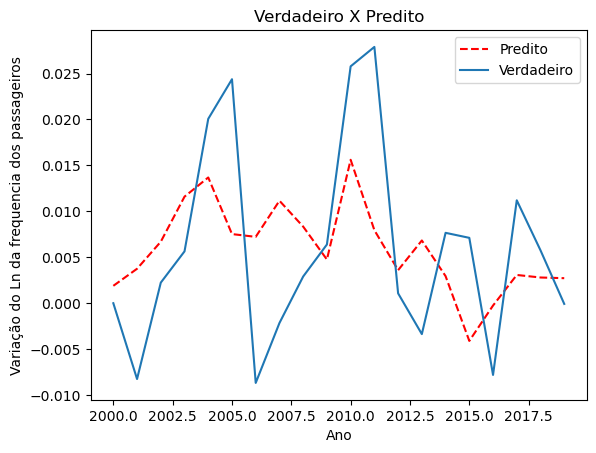

In [235]:
ypred = model.predict(x)
ano_lista = np.arange(2000,2020,1)


plt.plot(ano_lista,ypred,'--r', label='Predito')
plt.plot(ano_lista, principal_slz["Passageiros_frequencia"], label = 'Verdadeiro' )
plt.title("Verdadeiro X Predito")
plt.xlabel("Ano")
plt.ylabel("Variação do Ln da frequencia dos passageiros")
plt.legend()
plt.show()